# 🌸 MobileNetV2 Image Classification

<details>
<summary><strong>📋 About This Project & Objectives</strong></summary>

In this exercise, the lightweight network MobileNetV2 is used to classify flower image datasets. This project demonstrates advanced computer vision techniques using a mobile-optimized architecture.

**Learning Objectives:**

- 🌺 Master flower image dataset preprocessing and augmentation techniques
- 🏗️ Build and configure MobileNetV2 architecture for transfer learning
- ⚙️ Implement fine-tuning strategies for pre-trained models
- 📈 Evaluate model performance on multi-class image classification

</details>

## 📚 Imports and Environment Setup
Setting up the required libraries and environment for MobileNetV2 image classification.

In [ ]:
# Import the Python library and module and configure running information.
from warnings import filterwarnings
filterwarnings('ignore')

import mindspore.dataset.vision.c_transforms as CV
from mindspore import dtype as mstype

## 🌺 Dataset Loading and Exploration
Processing the flower image dataset for classification with MobileNetV2.

In [ ]:
# Read flower dataset
import matplotlib.pyplot as plt
import numpy as np
import mindspore.dataset as ds

# Dataset paths
train_data_path = '../flower_photos_train'
val_data_path = '../flower_photos_test'


def create_dataset(data_path, batch_size=18, training=True):
    """Define the dataset."""
    data_set = ds.ImageFolderDataset(data_path, num_parallel_workers=8, shuffle=True,
                                     class_indexing={'daisy': 0, 'dandelion': 1, 'roses': 2, 
                                                     'sunflowers': 3, 'tulips': 4})
    # Perform image enhancement on the dataset.
    image_size = 224
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if training:
        trans = [
            CV.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            CV.RandomHorizontalFlip(prob=0.5),
            CV.Normalize(mean=mean, std=std),
            CV.HWC2CHW()
        ]
    else:
        trans = [
            CV.Decode(),
            CV.Resize(256),
            CV.CenterCrop(image_size),
            CV.Normalize(mean=mean, std=std),
            CV.HWC2CHW()
        ]
    # Perform the data map, batch, and repeat operations.
    data_set = data_set.map(operations=trans, input_columns="image", num_parallel_workers=8)
    data_set = data_set.batch(batch_size, drop_remainder=True)
    return data_set


# Create training and validation datasets
dataset_train = create_dataset(train_data_path)
dataset_val = create_dataset(val_data_path)

# Display dataset information
data = next(dataset_train.create_dict_iterator())
images = data["image"]
labels = data["label"]
print("Tensor of image", images.shape)
print("Labels:", labels)

[WARNING] ME(12167:133474519167104,MainProcess):2025-09-10-13:55:51.166.805 [mindspore/dataset/core/validator_helpers.py:744] 'RandomCropDecodeResize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomCropDecodeResize' from mindspore.dataset.vision instead.
[WARNING] ME(12167:133474519167104,MainProcess):2025-09-10-13:55:51.167.742 [mindspore/dataset/core/validator_helpers.py:744] 'RandomHorizontalFlip' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'RandomHorizontalFlip' from mindspore.dataset.vision instead.
[WARNING] ME(12167:133474519167104,MainProcess):2025-09-10-13:55:51.168.328 [mindspore/dataset/core/validator_helpers.py:744] 'Normalize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Normalize' from mindspore.dataset.vision instead.
[WARNING] ME(12167:133474519

Tensor of image (18, 3, 224, 224)
Labels: [0 4 0 2 3 4 3 3 1 1 4 2 1 1 2 3 0 4]


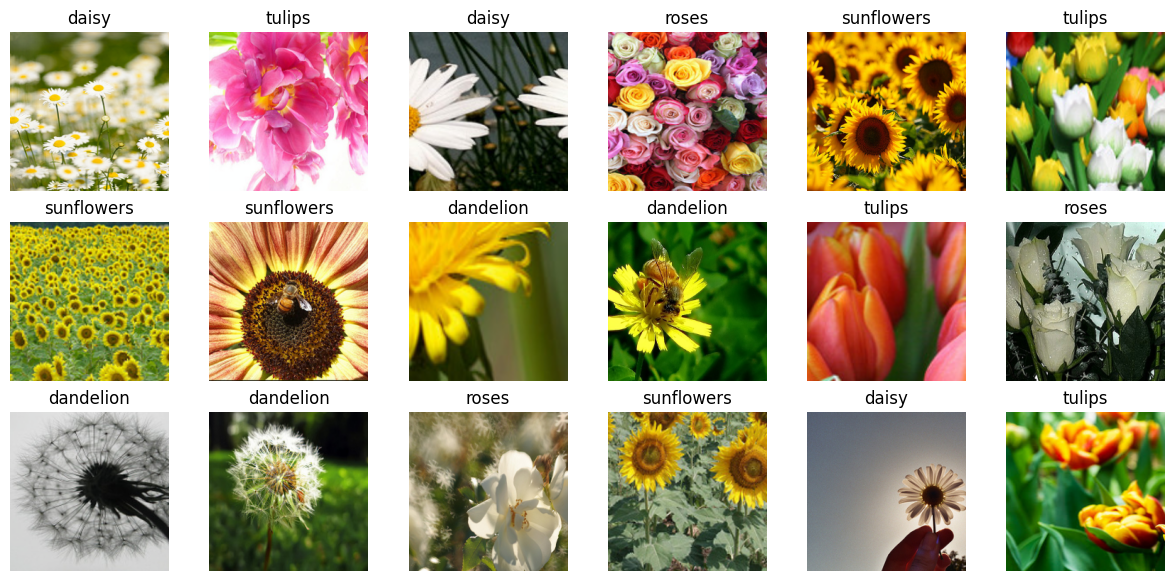

In [22]:
# Visualize batch of flower images
# class_name corresponds to label. Labels are marked in ascending order of the folder characterstring.
class_name = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}

# Define denormalization parameters
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(15, 7))
for i in range(len(labels)):
    # Obtain an image and its label
    image = images[i].asnumpy()
    # Convert from CHW to HWC format for matplotlib
    image = np.transpose(image, (1, 2, 0))
    # Denormalize the image
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    label = class_name[int(labels[i].asnumpy())]
    plt.subplot(3, 6, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
plt.show()

## 🏗️ MobileNetV2 Architecture
Building the MobileNetV2 network for efficient flower image classification.

In [ ]:
# MobileNetV2 Implementation for flower classification
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops


def _make_divisible(v, divisor, min_value=None):
    """Make channel number divisible by divisor."""
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class GlobalAvgPooling(nn.Cell):
    """Global average pooling layer."""
    def __init__(self):
        super(GlobalAvgPooling, self).__init__()
        self.mean = ops.ReduceMean(keep_dims=False)
    
    def construct(self, x):
        x = self.mean(x, (2, 3))
        return x

In [24]:
# ConvBNReLU building block
class ConvBNReLU(nn.Cell):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        super(ConvBNReLU, self).__init__()
        padding = (kernel_size - 1) // 2
        in_channels = in_planes
        out_channels = out_planes
        if groups == 1:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='pad', 
                           padding=padding)
        else:
            out_channels = in_planes
            conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad_mode='pad',
                           padding=padding, group=in_channels)
        layers = [conv, nn.BatchNorm2d(out_planes), nn.ReLU6()]
        self.features = nn.SequentialCell(layers)
    
    def construct(self, x):
        output = self.features(x)
        return output

In [25]:
# InvertedResidual block - core MobileNetV2 building block
class InvertedResidual(nn.Cell):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]
        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = stride == 1 and inp == oup
        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, has_bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.SequentialCell(layers)
        self.add = ops.Add()
        self.cast = ops.Cast()
    
    def construct(self, x):
        identity = x
        x = self.conv(x)
        if self.use_res_connect:
            return self.add(identity, x)
        return x

In [26]:
# MobileNetV2 Backbone - feature extraction network
class MobileNetV2Backbone(nn.Cell):
    def __init__(self, width_mult=1., inverted_residual_setting=None, round_nearest=8,
                 input_channel=32, last_channel=1280):
        super(MobileNetV2Backbone, self).__init__()
        block = InvertedResidual
        # setting of inverted residual blocks
        self.cfgs = inverted_residual_setting
        if inverted_residual_setting is None:
            self.cfgs = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]
        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.out_channels = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2)]
        # building inverted residual blocks
        for t, c, n, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.out_channels, kernel_size=1))
        # make it nn.CellList
        self.features = nn.SequentialCell(features)
        self._initialize_weights()
    
    def construct(self, x):
        x = self.features(x)
        return x
    
    def _initialize_weights(self):
        self.init_parameters_data()
        for _, m in self.cells_and_names():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.set_data(ms.Tensor(np.random.normal(0, np.sqrt(2. / n),
                                                            m.weight.data.shape).astype("float32")))
                if m.bias is not None:
                    m.bias.set_data(ms.numpy.zeros(m.bias.data.shape, dtype="float32"))
            elif isinstance(m, nn.BatchNorm2d):
                m.gamma.set_data(ms.Tensor(np.ones(m.gamma.data.shape, dtype="float32")))
                m.beta.set_data(ms.numpy.zeros(m.beta.data.shape, dtype="float32"))
    
    @property
    def get_features(self):
        return self.features

In [27]:
# MobileNetV2 Head - classification head
class MobileNetV2Head(nn.Cell):
    def __init__(self, input_channel=1280, num_classes=1000, has_dropout=False, activation="None"):
        super(MobileNetV2Head, self).__init__()
        # mobilenet head
        head = ([GlobalAvgPooling()] if not has_dropout else
                [GlobalAvgPooling(), nn.Dropout(0.2)])
        self.head = nn.SequentialCell(head)
        self.dense = nn.Dense(input_channel, num_classes, has_bias=True)
        self.need_activation = True
        if activation == "Sigmoid":
            self.activation = nn.Sigmoid()
        elif activation == "Softmax":
            self.activation = nn.Softmax(axis=1)
        else:
            self.need_activation = False
        self._initialize_weights()
    
    def construct(self, x):
        x = self.head(x)
        x = self.dense(x)
        if self.need_activation:
            x = self.activation(x)
        return x
    
    def _initialize_weights(self):
        self.init_parameters_data()
        for _, m in self.cells_and_names():
            if isinstance(m, nn.Dense):
                m.weight.set_data(ms.Tensor(np.random.normal(
                    0, 0.01, m.weight.data.shape).astype("float32")))
                if m.bias is not None:
                    m.bias.set_data(ms.numpy.zeros(m.bias.data.shape, dtype="float32"))

In [28]:
# Complete MobileNetV2 model - combining backbone and head
class MobileNetV2Combine(nn.Cell):
    def __init__(self, backbone, head):
        super(MobileNetV2Combine, self).__init__(auto_prefix=False)
        self.backbone = backbone
        self.head = head
    
    def construct(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

def mobilenet_v2(num_classes):
    backbone_net = MobileNetV2Backbone()
    head_net = MobileNetV2Head(backbone_net.out_channels, num_classes)
    return MobileNetV2Combine(backbone_net, head_net)

## ⚙️ Loss Function and Optimizer Configuration
Setting up the training components for MobileNetV2 optimization.

In [29]:
# Define loss function and metrics
import mindspore.nn as nn

# Simple cross-entropy loss for classification
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# Basic accuracy metric
from mindspore.nn.metrics import Accuracy
accuracy_metric = Accuracy()

print("Loss function and metrics configured successfully!")
print(f"Loss: {loss_fn}")
print(f"Metric: {accuracy_metric}")
print("Note: Optimizer will be configured later when model parameters are available")

Loss function and metrics configured successfully!
Loss: SoftmaxCrossEntropyWithLogits<>
Metric: <mindspore.train.metrics.accuracy.Accuracy object at 0x7964a1b36510>
Note: Optimizer will be configured later when model parameters are available


## 📈 Model Training
Training the MobileNetV2 network on the flower image dataset.

In [30]:
# Model Creation and Pre-trained Weights Loading
import mindspore
import mindspore.nn as nn
from mindspore.train import Model
from mindspore import Tensor, save_checkpoint
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net

# Create a model. The number of target classes is 5.
network = mobilenet_v2(5)

# Load the pre-trained weight.
param_dict = load_checkpoint("mobilenetv2_ascend_v170_imagenet2012_official_cv_top1acc71.88.ckpt")

# Modify the weight data based on the modified model structure.
param_dict["dense.weight"] = mindspore.Parameter(Tensor(param_dict["dense.weight"][:5, :], mindspore.float32), 
                                                 name="dense.weight", requires_grad=True)
param_dict["dense.bias"] = mindspore.Parameter(Tensor(param_dict["dense.bias"][:5, ], mindspore.float32), 
                                              name="dense.bias", requires_grad=True)

# Load the modified weight parameters to the model.
load_param_into_net(network, param_dict)

print("Model created and pre-trained weights loaded successfully!")
print(f"Model: {network.__class__.__name__}")
print("Pre-trained weights adapted for 5-class flower classification")

Model created and pre-trained weights loaded successfully!
Model: MobileNetV2Combine
Pre-trained weights adapted for 5-class flower classification


In [31]:
# Learning Rate Schedule and Optimizer Configuration
train_step_size = dataset_train.get_dataset_size()
epoch_size = 5

# Create cosine decay learning rate schedule
lr = nn.cosine_decay_lr(min_lr=0.0, max_lr=0.1, 
                       total_step=epoch_size * train_step_size,
                       step_per_epoch=train_step_size, 
                       decay_epoch=200)

# Define the optimizer with momentum
network_opt = nn.Momentum(params=network.trainable_params(), 
                         learning_rate=0.01, 
                         momentum=0.9)

In [ ]:
# Model Compilation and Callbacks Setup

# Define the loss function and metrics
net_loss = loss_fn
metrics = {"Accuracy": accuracy_metric}

# Initialize the model
model = Model(network, loss_fn=net_loss, optimizer=network_opt, metrics=metrics)

# Configure training callbacks
loss_cb = LossMonitor(per_print_times=train_step_size)
config_ck = CheckpointConfig(save_checkpoint_steps=train_step_size, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="mobilenet_v2", directory="./checkpoints", config=config_ck)

In [33]:
# Training Execution and Evaluation
print("============== Starting Training ==============")

# Train a model, set the number of training times to 5, and set the training set and callback function
model.train(5, dataset_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=True)

# Use the test set to validate the model and output the accuracy of the test set
metric = model.eval(dataset_val)
print(metric)

============== Starting Training ==============
epoch: 1 step: 201, loss is 0.6172635555267334
epoch: 1 step: 201, loss is 0.6172635555267334
epoch: 2 step: 201, loss is 1.4943716526031494
epoch: 2 step: 201, loss is 1.4943716526031494
epoch: 3 step: 201, loss is 0.03894852101802826
epoch: 3 step: 201, loss is 0.03894852101802826
epoch: 4 step: 201, loss is 0.3091883659362793
epoch: 4 step: 201, loss is 0.3091883659362793
epoch: 5 step: 201, loss is 0.237495556473732
epoch: 5 step: 201, loss is 0.237495556473732
{'Accuracy': 0.9166666666666666}
{'Accuracy': 0.9166666666666666}


## 🎯 Model Evaluation and Testing
Validating the trained MobileNetV2 model on the flower test dataset.

In [ ]:
# Evaluate model on test dataset
import numpy as np
import mindspore.ops as ops

print("🎯 Comprehensive Model Evaluation")
print("=" * 50)

# 1. Overall accuracy on validation set
if 'model' in locals():
    result = model.eval(dataset_val, dataset_sink_mode=True)
    overall_accuracy = result['Accuracy']
    print(f"Overall Validation Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    
    # 2. Per-class accuracy analysis
    class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    class_correct = [0] * 5
    class_total = [0] * 5
    
    # Set model to evaluation mode
    network.set_train(False)
    
    # Iterate through validation dataset for detailed analysis
    for data in dataset_val.create_dict_iterator():
        images = data["image"]
        labels = data["label"]
        
        # Get model predictions
        outputs = network(images)
        predicted = ops.Argmax(axis=1)(outputs)
        
        # Calculate per-class accuracy
        for i in range(labels.shape[0]):
            label = int(labels[i].asnumpy())
            pred = int(predicted[i].asnumpy())
            class_total[label] += 1
            if label == pred:
                class_correct[label] += 1
    
    # Display per-class results
    print(f"\nPer-Class Accuracy:")
    print("-" * 30)
    for i in range(5):
        if class_total[i] > 0:
            accuracy = class_correct[i] / class_total[i]
            print(f"{class_names[i]:12}: {accuracy:.4f} ({accuracy*100:.2f}%) - {class_correct[i]}/{class_total[i]} samples")
        else:
            print(f"{class_names[i]:12}: No samples in validation set")
    
    # Model complexity information
    total_params = sum([param.size for param in network.get_parameters()])
    print(f"\nModel Complexity:")
    print("-" * 20)
    print(f"Total parameters: {total_params:,}")
    print(f"Model size (approx): {total_params * 4 / 1024 / 1024:.2f} MB")
    
else:
    print("Model not found. Please run the training cells first.")

🎯 Comprehensive Model Evaluation
Overall Validation Accuracy: 0.8611 (86.11%)
Overall Validation Accuracy: 0.8611 (86.11%)

Per-Class Accuracy:
------------------------------
daisy       : 0.8333 (83.33%) - 5/6 samples
dandelion   : 1.0000 (100.00%) - 8/8 samples
roses       : 0.8571 (85.71%) - 6/7 samples
sunflowers  : 1.0000 (100.00%) - 6/6 samples
tulips      : 0.5556 (55.56%) - 5/9 samples

Model Complexity:
--------------------
Total parameters: 2,264,389
Model size (approx): 8.64 MB

Per-Class Accuracy:
------------------------------
daisy       : 0.8333 (83.33%) - 5/6 samples
dandelion   : 1.0000 (100.00%) - 8/8 samples
roses       : 0.8571 (85.71%) - 6/7 samples
sunflowers  : 1.0000 (100.00%) - 6/6 samples
tulips      : 0.5556 (55.56%) - 5/9 samples

Model Complexity:
--------------------
Total parameters: 2,264,389
Model size (approx): 8.64 MB


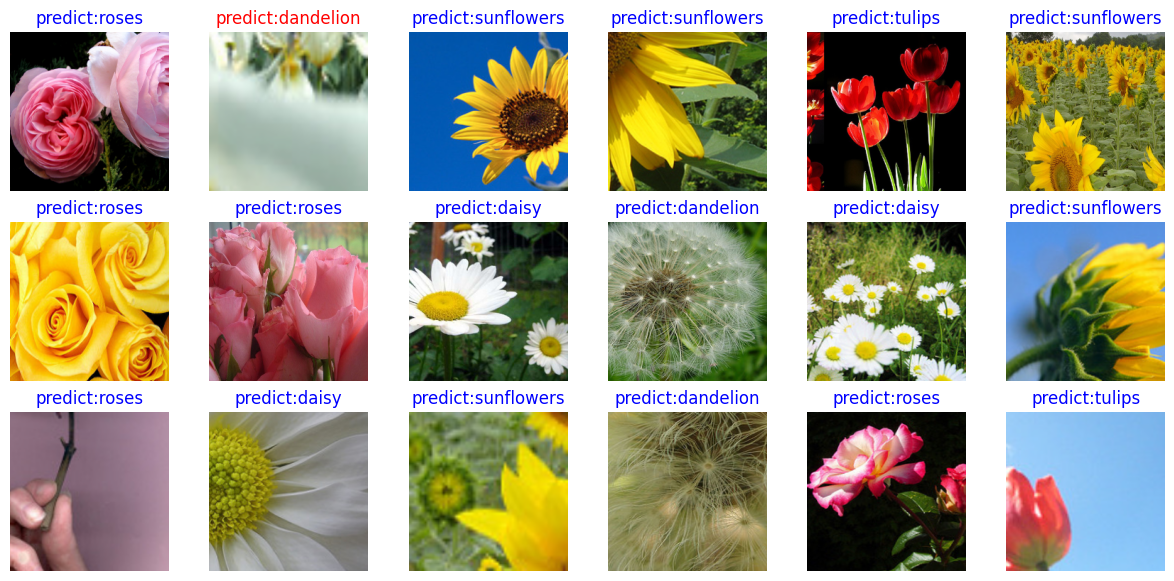

In [ ]:
# Visualize the model prediction result
import matplotlib.pyplot as plt
import mindspore as ms

def visualize_model(best_ckpt_path, val_ds):
    """Visualize model predictions on validation dataset."""
    # Create model and load checkpoint
    num_class = 5
    net = mobilenet_v2(num_class)
    param_dict = load_checkpoint(best_ckpt_path)
    load_param_into_net(net, param_dict)
    
    # Get validation data
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    class_name = {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}
    
    # Make predictions
    output = model.predict(ms.Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)
    
    # Visualization parameters
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Display predictions
    plt.figure(figsize=(15, 7))
    for i in range(len(labels)):
        plt.subplot(3, 6, i + 1)
        
        # Color coding: blue for correct, red for incorrect
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color)
        
        # Denormalize and display image
        picture_show = np.transpose(images[i], (1, 2, 0))
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')
    
    plt.show()


# Call the visualization function
visualize_model('./checkpoints/mobilenet_v2-5_201.ckpt', dataset_val)